# Monte Carlo Hedge
1. Import the libraries
0. Define the parameters
1. Read the data
2. Simulate the prices
3. Calculate the g vector
4. Calculate the real option
5. Display and save the results

In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import read_data as rd
import simulations as sm
import g_functions as gf
import options as op



## Define Parameters

### Dates and Duration

In [2]:
valuation_date = dt.datetime(2024, 1, 1)

# Possible first day of the project
starting_day = 30

# Possibles days to execute the project after the starting day
oportunitty_window = 60
# Duration of the project after it starts
project_duration = 90 

# Maximum of days of the project
n_days_forecast = starting_day + oportunitty_window + project_duration 

dates_parameters = {}
dates_parameters['valuation_date'] = valuation_date
dates_parameters['starting_day'] = starting_day
dates_parameters['oportunitty_window'] = oportunitty_window
dates_parameters['project_duration'] = project_duration
dates_parameters['n_days_forecast'] = n_days_forecast

# # Number of steps for the random walk
# num_steps = int(T * n_days) + 1 # Using the projection_days from the preceding code
# delta_time = 1 / n_days # Time step (Δ)

### Project Cost

In [3]:
# Fixed costs
k = 0.5
# Initial Investment
K = 2000
# Electricity conversion factor
# kappa = 0.9
kappa = 5

investment_parameters = {
    'k': k,
    'K': K,
    'kappa': kappa
  }
  

### Other Parameters

In [4]:
# data_path = 'C:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\data'
data_path = 'C:/Users/fe_ma/Data/'

n_simulations = 10000
rho = 0.05
delta_time = 1 / 365

others_parameters = {
    'rho': rho,
    'delta_time': delta_time
}

## Read the data
In this section, we load the necessary financial and operational data from CSV files. The data includes:
- **Hashprice**: Revenue per unit of hash rate.
- **Bitcoin Price (BTC)**: Historical price data.
- **Electricity Price**: Historical electricity costs.

The `read_data` function handles the loading and preprocessing of these datasets.

In [5]:
df_data = rd.read_data(data_path)

### Preprocessing
We filter the data to include only the training period, which ends on the `valuation_date`. This ensures that our simulation is based on historical data available up to the point of valuation.

In [6]:
n_train = 1000
df_data_train = df_data[valuation_date - dt.timedelta(days=n_train): valuation_date]

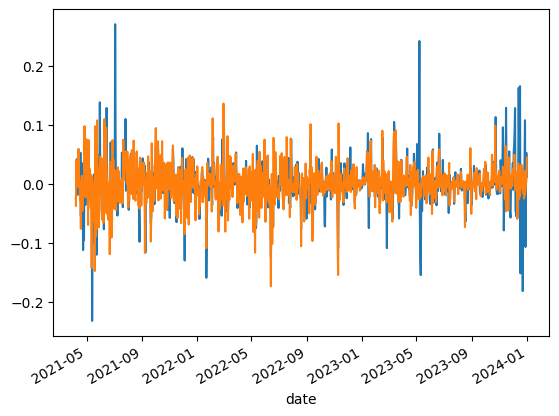

In [7]:
df_data_ret = np.log(df_data_train)
df_data_ret[['hashprice', 'btc']] = df_data_ret[['hashprice', 'btc']].diff()
df_data_ret.dropna(inplace=True)

# df_data_ret.plot()
fit_models = {'hashprice': 'brownian', 'btc': 'brownian', 'electricity': 'fit_electricity'}

for key, model in fit_models.items():
  if model == 'brownian':
    df_data_ret[key].plot()

## Simulations
This section focuses on simulating the future paths of the underlying assets (Hashprice, BTC, and Electricity). We use a multivariate Monte Carlo simulation approach that accounts for the correlations between these assets.

### Fit models
Before simulating, we need to fit statistical models to our historical data:
1.  **Electricity**: Modeled with a seasonal component (sine/cosine functions) and an AR(1) process for residuals to capture mean-reversion and seasonality.
2.  **Hashprice & BTC**: Modeled as Geometric Brownian Motion (GBM) via their log returns.

We also calculate the covariance matrix of the residuals/returns to ensure the simulations preserve the historical correlations between the assets.

In [8]:
# Step 1: Fit electricity model with seasonal + AR(1) structure
print("Fitting Electricity Model (Seasonal + AR(1))...")
print("=" * 60)

df_electricity_fit, electricity_params = sm.fit_electricity(df_data_ret)
electricity_residuals = df_electricity_fit['residual_ar'].dropna()

# Step 2: Align electricity residuals with hashprice/btc returns
brownian_series = [key for key, model in fit_models.items() if model == 'brownian']
df_returns_brownian = df_data_ret[brownian_series].copy()

df_combined = df_returns_brownian.copy()
df_combined['electricity'] = electricity_residuals
df_combined = df_combined.dropna()

multivariate_params = sm.calculate_multivariate_params(df_combined)

Fitting Electricity Model (Seasonal + AR(1))...


### Simulations of returns
We generate `n_simulations` paths for each asset over the forecast horizon (`n_days_forecast`).
- **Hashprice & BTC**: Simulated using random shocks correlated via Cholesky decomposition.
- **Electricity**: Simulated by projecting the seasonal component and adding AR(1) residuals driven by correlated shocks.

In [9]:
# Generate multivariate simulations with electricity AR(1) + correlation

print("Generating Multivariate Monte Carlo simulations...")
print(f"  - Hashprice & BTC: Brownian motion with Itô correction")
print(f"  - Electricity: Seasonal + AR(1) residuals with correlation")
print(f"Simulating {n_simulations} paths over {n_days_forecast} days")
print("=" * 60)

# Get start date (day after last training date)
start_date = df_data_ret.index[-1] + pd.Timedelta(days=1)

# Simulate all series together with covariance and electricity AR(1)
simulations = sm.simulate_multivariate_with_electricity(
    multivariate_params=multivariate_params,
    electricity_params=electricity_params,
    n_days=n_days_forecast,
    n_simulations=n_simulations,
    start_date=start_date,
    random_seed=42
)

Generating Multivariate Monte Carlo simulations...
  - Hashprice & BTC: Brownian motion with Itô correction
  - Electricity: Seasonal + AR(1) residuals with correlation
Simulating 10000 paths over 180 days


### Converting simulations to Price
The simulations are performed on log returns (or log prices for electricity). In this step, we convert these simulated values back to actual price levels to be used in the valuation logic.

In [10]:
price_simulations = sm.convert_to_price(simulations, df_data_train)

In [11]:
price_simulations['hashprice']

array([[ 98.96      , 100.60378242, 106.24064065, ...,  85.59141951,
         83.38642536,  82.04709292],
       [ 98.96      , 101.87584306, 107.25961034, ..., 138.89668002,
        143.84287158, 141.30416328],
       [ 98.96      ,  97.50019964, 105.09830093, ..., 247.84354201,
        245.71444097, 238.49908804],
       ...,
       [ 98.96      , 103.08387648, 102.88812767, ...,  38.83698703,
         38.76213331,  38.10348141],
       [ 98.96      , 103.89620682, 106.08904251, ...,  17.01578883,
         17.6303872 ,  17.50595855],
       [ 98.96      ,  99.42947166, 102.14154604, ...,  32.93440831,
         33.2656985 ,  36.46335719]], shape=(10000, 181))

## G Estimation
We estimate the coefficients `alpha` for the function `g(x, y)`. This function approximates the project value or decision boundary. We use a regression approach based on the simulated prices.

In [12]:
dates = [valuation_date + dt.timedelta(days=i) for i in range(n_days_forecast + 1)]

prices = {}
prices['X'] = pd.DataFrame(price_simulations['hashprice'], columns=dates)
prices['Y'] = pd.DataFrame(price_simulations['electricity'], columns=dates)

In [13]:
g_alpha = gf.estimate_g_alpha(prices, dates_parameters, investment_parameters, others_parameters)

## Run Process

### Prepare Data

In [14]:
# Prepare DataFrames to store the results of the backward induction

project_duration = dates_parameters['project_duration']
dates_project_window = [valuation_date + dt.timedelta(days=i) for i in range(n_days_forecast + 1 - project_duration)]

In [15]:
functional_results = {}
option_results = {}
intrinsic_results = {}

### Only Polinomial

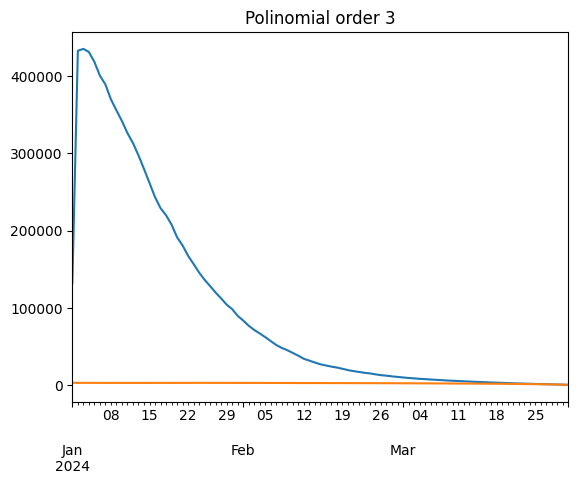

In [16]:
for i in range(1, 3):

  basis_type = {'pol_order': i + 1, 'option_basis': None}
  df_option_value, df_call_value, df_intrinsic_value, df_delta, functional_result = op.calculate_real_option(prices, basis_type, dates_project_window, dates_parameters, investment_parameters, others_parameters)

  functional_results[f'only_polinomial_{i+1}'] = functional_result
  option_results[f'only_polinomial_{i+1}'] = df_option_value
  intrinsic_results[f'only_polinomial_{i+1}'] = df_intrinsic_value
  df_option_value.mean().plot(title=f'Polinomial order {i + 1}')


### Margrabe

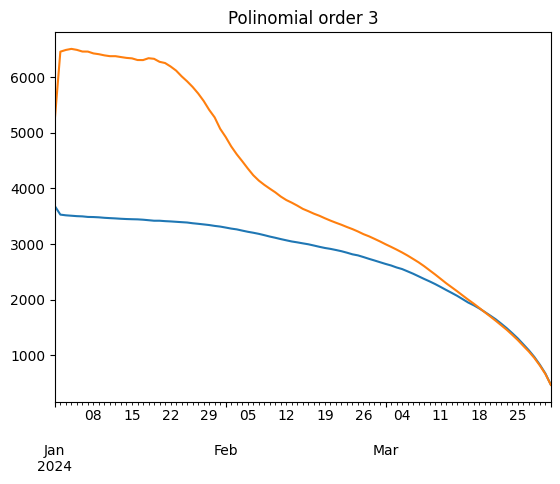

In [17]:
for i in range(1, 3):
  basis_type = {'pol_order': i + 1, 'option_basis': 'margrabe'}
  df_option_value, df_call_value, df_intrinsic_value, df_delta, functional_result = op.calculate_real_option(prices, basis_type, dates_project_window, dates_parameters, investment_parameters, others_parameters)

  functional_results[f'margrabe_{i+1}'] = functional_result
  option_results[f'margrabe_{i+1}'] = df_option_value
  intrinsic_results[f'margrabe_{i+1}'] = df_intrinsic_value
  df_option_value.mean().plot(title=f'Polinomial order {i + 1}')

## Results

<Axes: >

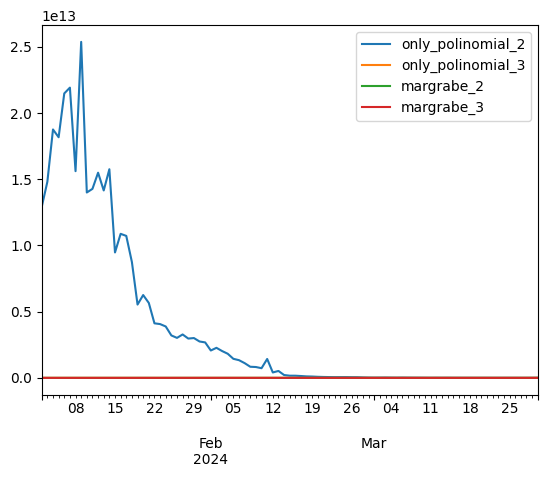

In [18]:
df_results = pd.DataFrame(functional_results)
df_results.plot()

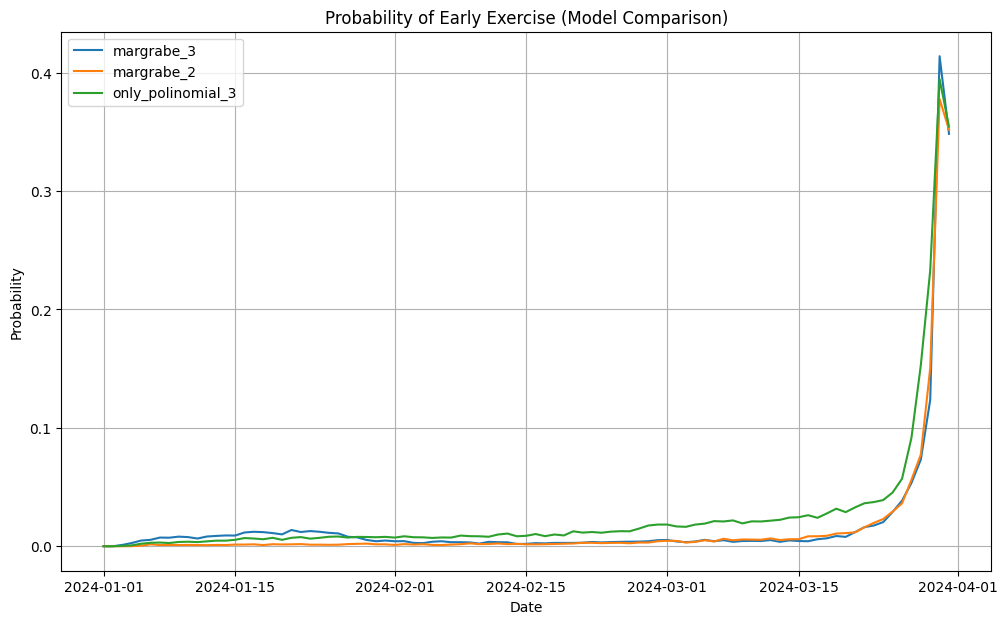

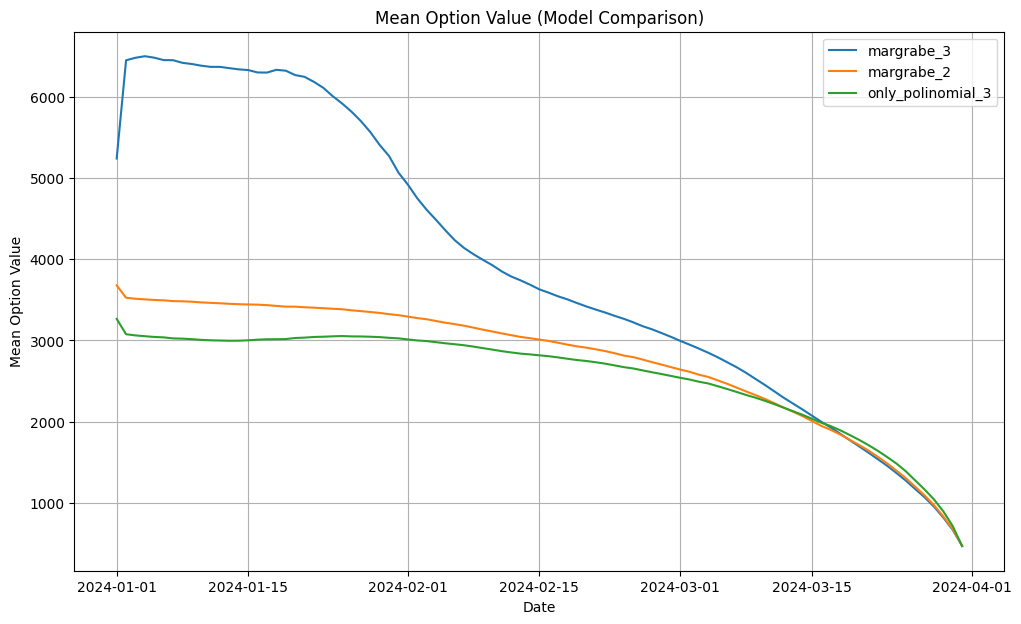

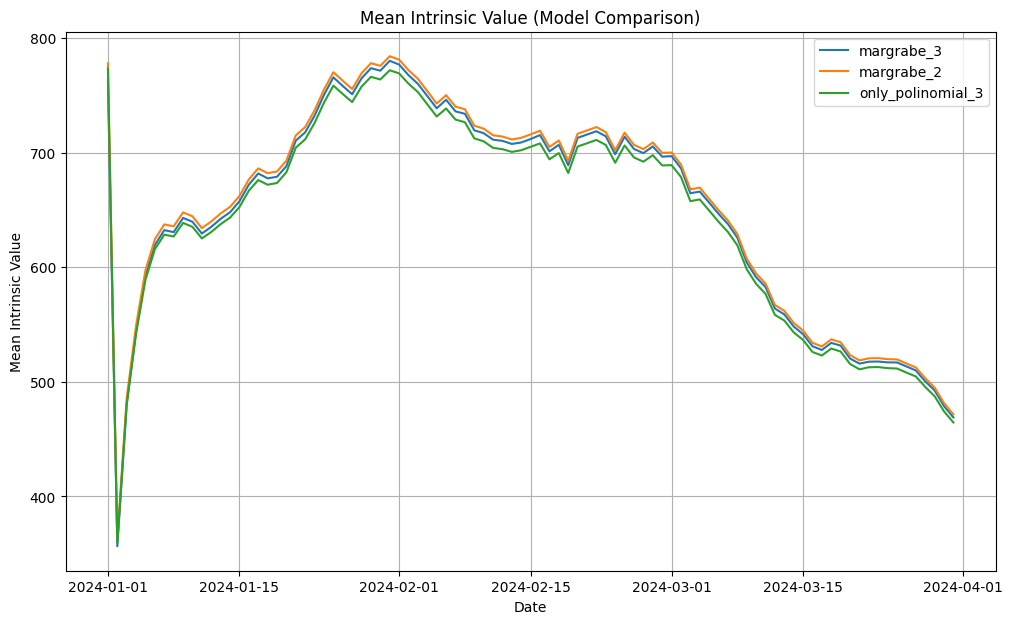

In [19]:
import matplotlib.pyplot as plt

# models = ['only_polinomial_2', 'margrabe_2']
models = ['margrabe_3', 'margrabe_2', 'only_polinomial_3']

# === 1️⃣ Compare Probability of Early Exercise ===
plt.figure(figsize=(12, 7))

for model in models:
    df_option_value = option_results[model]
    df_intrinsic_value = intrinsic_results[model]

    # Compute probability of early exercise
    df_prob_aux = df_option_value.copy() * 0
    df_prob_aux[df_option_value <= df_intrinsic_value] = 1

    date_end = df_prob_aux.columns[-1]
    df_prob_aux[date_end] = (df_intrinsic_value[date_end] > 0).astype(int)

    prob_series = df_prob_aux.sum() / len(df_prob_aux)
    plt.plot(prob_series.index, prob_series.values, label=f'{model}')

plt.title('Probability of Early Exercise (Model Comparison)')
plt.xlabel('Date')
plt.ylabel('Probability')
plt.grid(True)
plt.legend()
plt.show()


# === 2️⃣ Compare Mean Option Value ===
plt.figure(figsize=(12, 7))

for model in models:
    df_option_value = option_results[model]
    mean_series = df_option_value.mean()
    plt.plot(mean_series.index, mean_series.values, label=f'{model}')

plt.title('Mean Option Value (Model Comparison)')
plt.xlabel('Date')
plt.ylabel('Mean Option Value')
plt.grid(True)
plt.legend()
plt.show()

# === 3️⃣ Compare Mean Intrinsic Value ===
plt.figure(figsize=(12, 7))

for model in models:
    df_intrinsic_value = intrinsic_results[model]
    mean_series = df_intrinsic_value.mean()
    plt.plot(mean_series.index, mean_series.values, label=f'{model}')

plt.title('Mean Intrinsic Value (Model Comparison)')
plt.xlabel('Date')
plt.ylabel('Mean Intrinsic Value')
plt.grid(True)
plt.legend()
plt.show()